In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
data_path = '/content/drive/My Drive/data/'

In [ ]:
# https://medium.com/analytics-vidhya/search?q=Neural%20Machine%20Translation
# https://medium.com/@topgyaltsering/neural-machine-translation-technique-powering-google-translate-dfe8dc932b0c
# dataset
# http://www.manythings.org/anki/

In [ ]:
import string 
import re 
from numpy import array, argmax, random, take 
import pandas as pd 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 
import matplotlib.pyplot as plt 
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [ ]:
file_name = 'ukr_eng.txt'
file_path = data_path + file_name

In [ ]:
def prepareString(s):
    return s.split('CC-BY 2.0')[0].strip()

In [ ]:
# split text into sentences 
def to_lines(text): 
      sents = text.strip().split('\n') 
      sents = [prepareString(line).split('\t') for line in sents] 
      return sents

In [ ]:
def read_text(file_path):
  with open(file_path, 'r') as reader:
    data = reader.read()
    print(data)
    return data

In [ ]:
data = read_text(file_path)
ukr_eng = to_lines(data) 
ukr_eng = array(ukr_eng)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
len(ukr_eng)

137864

In [ ]:
ukr_eng

array([['Go.', 'Йди.'],
       ['Hi.', 'Вітаю!'],
       ['Hi.', 'Привіт.'],
       ...,
       ['The English language is undoubtedly the easiest and at the same time the most efficient means of international communication.',
        'Англійська мова є, без сумніву, найпростішим та, водночас, найефективнішим засобом міжнародного спілкування.'],
       ['If you take a child outside and point at the moon, they will look at the moon. If you do the same thing with a dog, it will look at your finger.',
        'Якщо вивести дитину на вулицю і показати їй на місяць, вона дивитиметься на місяць. Якщо зробити те ж саме з собакою, він дивитиметься на палець.'],
       ['When writing a sentence, generally you start with a capital letter and finish with a period (.), an exclamation mark (!), or a question mark (?).',
        'При написанні речення, його зазвичай починають з великої літери, і закінчують крапкою (.), знаком оклику (!), або знаком питання (?).']],
      dtype='<U147')

## We will get rid of the punctuation marks and then convert all the text to lower case.

In [ ]:
# Remove punctuation 
ukr_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ukr_eng[:,0]] 
ukr_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ukr_eng[:,1]] 

# convert text to lowercase 
for i in range(len(ukr_eng)): 
    ukr_eng[i,0] = ukr_eng[i,0].lower() 
    ukr_eng[i,1] = ukr_eng[i,1].lower()

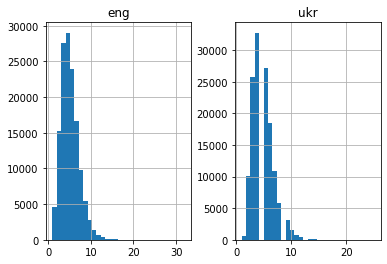

In [ ]:
# empty lists 
eng_l = [] 
ukr_l = [] 

# populate the lists with sentence lengths 
for i in ukr_eng[:,0]: 
      eng_l.append(len(i.split())) 

for i in ukr_eng[:,1]: 
      ukr_l.append(len(i.split())) 

length_df = pd.DataFrame({'eng':eng_l, 'ukr':ukr_l}) 
length_df.hist(bins = 30) 
plt.show()

In [ ]:
# function to build a tokenizer 
def tokenization(lines): 
      tokenizer = Tokenizer() 
      tokenizer.fit_on_texts(lines) 
      return tokenizer

# prepare english tokenizer 
eng_tokenizer = tokenization(ukr_eng[:, 0]) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 15

# print('English Vocabulary Size: %d' % eng_vocab_size)

# prepare Ukraininan tokenizer 
ukr_tokenizer = tokenization(ukr_eng[:, 1]) 
ukr_vocab_size = len(ukr_tokenizer.word_index) + 1 
ukr_length = 15 


In [ ]:
# encode and pad sequences 
def encode_sequences(tokenizer, length, lines):          
         # integer encode sequences          
         seq = tokenizer.texts_to_sequences(lines)          
         # pad sequences with 0 values          
         seq = pad_sequences(seq, maxlen=length, padding='post')           
         return seq

## Model Building

In [ ]:
from sklearn.model_selection import train_test_split 

# split data into train and test set 
train, test= train_test_split(ukr_eng,test_size=0.2,random_state= 12)

In [ ]:
# prepare training data 
trainX = encode_sequences(ukr_tokenizer, ukr_length, train[:, 1]) 
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0]) 

# prepare validation data 
testX = encode_sequences(ukr_tokenizer, ukr_length, test[:, 1]) 
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

## Seq2Seq model architecture:
For the encoder, we will use an embedding layer and an LSTM layer

For the decoder, we will use another LSTM layer followed by a dense layer

In [ ]:
# build NMT model 
def build_model(in_vocab,out_vocab, in_timesteps,out_timesteps,n):   
      model = Sequential() 
      model.add(Embedding(in_vocab, n, input_length=in_timesteps, 
      mask_zero=True)) 
      model.add(LSTM(n)) 
      model.add(RepeatVector(out_timesteps)) 
      model.add(LSTM(n, return_sequences=True))  
      model.add(Dense(out_vocab, activation='softmax')) 
      return model 

In [ ]:
# model compilation (with 512 hidden units)
model = build_model(ukr_vocab_size, eng_vocab_size, ukr_length, eng_length, 512)

rms = optimizers.RMSprop(lr=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')


In [ ]:
model_name = 'translate_model.h1'
model_path = data_path + model_name

# set checkpoint
checkpoint = ModelCheckpoint(model_path, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min') 


# train model 
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=30, batch_size=512, validation_split = 0.2, 
                    callbacks=[checkpoint], verbose=1)

Train on 88232 samples, validate on 22059 samples
Epoch 1/30
88232/88232 [==============================] - 93s 1ms/step - loss: 2.4543 - val_loss: 2.1719

Epoch 00001: val_loss improved from inf to 2.17189, saving model to /content/drive/My Drive/data/translate_model.h1
Epoch 2/30
88232/88232 [==============================] - 93s 1ms/step - loss: 2.0912 - val_loss: 2.0023

Epoch 00002: val_loss improved from 2.17189 to 2.00228, saving model to /content/drive/My Drive/data/translate_model.h1
Epoch 3/30
88232/88232 [==============================] - 93s 1ms/step - loss: 1.9074 - val_loss: 1.8362

Epoch 00003: val_loss improved from 2.00228 to 1.83618, saving model to /content/drive/My Drive/data/translate_model.h1
Epoch 4/30
88232/88232 [==============================] - 93s 1ms/step - loss: 1.7215 - val_loss: 1.6795

Epoch 00004: val_loss improved from 1.83618 to 1.67948, saving model to /content/drive/My Drive/data/translate_model.h1
Epoch 5/30
88232/88232 [==========================

In [ ]:
model_name = 'translate_model.h1'
model_path = data_path + model_name

model = load_model(model_path)
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
testX.shape

(27573, 15)

In [ ]:
testX

array([[   36,     3,   148, ...,     0,     0,     0],
       [12572,    46,  1270, ...,     0,     0,     0],
       [    2,     3,    84, ...,     0,     0,     0],
       ...,
       [  184,   182,     0, ...,     0,     0,     0],
       [    9,  3345,  1792, ...,     0,     0,     0],
       [    1,    40,     4, ...,     0,     0,     0]], dtype=int32)